## Math 693A: Homework 1

Stephen Giang

RedID: 823184070

Due: 10-03-24


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

### Problem 1


Write a Program that implements the dogleg method. Choose $B_k$ to be the exact Hessian. Apply it to solve Rosenbrock’s function

$$
f(x) = 100(x_2 - x_1^2)^2 + (1 - x_1)^2
$$

Use an initial trust region radius of 1. Set maximum trust region radius to 300.
Use the initial point: $x_0 = [-1.2, 1]$ and then try another point $x_0 = [2.8, 4]$. Do the following for each of the initial points.

Additional information for the Dogleg Algorithm:

-   Use $||\nabla f(x_k)|| < 10^{-8}$ as the stopping criteria for your optimization algorithm.
-   State the total number of iterations obtained in your optimization algorithm.
-   Plot the objective function $f(x)$. On the same figure, plot the $x_k$ values at the different iterates of your optimization algorithm.
-   Plot the size of the objective function as a function of the iteration number. Use semi-log plot.
-   You should hand in (i) your code (ii) the first 6 and last 6 values of $x_k$ obtained from your program.
-   Determine the minimizer of the Rosenbrock function $x^*$.
-   Describe how you computed $\tau^*$ in the dogleg algorithm


First, Notice the following equations needed:

$$
\begin{align*}
    f(x) &= 100(x_2 - x_1^2)^2 + (1 - x_1)^2 \\
    \nabla f (x) &= \begin{pmatrix}
    400x_1^3 + 2x_1 - 400x_1x_2 - 2 \\
    200(x_2 - x_1^2)
    \end{pmatrix} \\
    \nabla^2f (x) &= \begin{pmatrix}
    1200x_1^2 - 400x_2 + 2 & -400x_1 \\
    - 400x_1 & 200
    \end{pmatrix}
\end{align*}
$$


In [2]:
f = lambda x: 100*(x[1] - x[0]**2)**2 + (1 - x[0])**2
grad_f = lambda x: np.array([400*x[0]**3 + 2*x[0] - 400*x[0]*x[1] - 2, 200 * (x[1] - x[0]**2)])
hess_f = lambda x: np.array([[1200*x[0]**2 - 400*x[1] + 2, -400*x[0]], [-400*x[0], 200]])

In [3]:
def dogleg(f, grad_f, hess_f, xk, dk, Bk):
    pk_dl = 0
    pk_u = -((np.matmul(np.transpose(grad_f(xk)), grad_f(xk))) / (np.matmul(np.transpose(grad_f(xk)), np.matmul(Bk, grad_f(xk))))) * grad_f(xk)
    pk_fs = -np.matmul(np.linalg.inv(Bk), grad_f(xk))

    if np.linalg.norm(pk_u) >= dk:
        pk_dl = dk * (pk_u) / np.linalg.norm(pk_u)
    elif np.linalg.norm(pk_fs) <= dk:
        pk_dl = pk_fs
    else:
        a = np.matmul(np.transpose(pk_fs - pk_u), pk_fs - pk_u)
        b = 2 * np.matmul(np.transpose(pk_u), pk_fs - pk_u)
        c = np.matmul(np.transpose(pk_u), pk_u) - dk**2
        tau = ((-b + np.sqrt(b**2 - (4*a*c))) / (2*a)) + 1
        pk_dl = pk_u + (tau - 1)*(pk_fs - pk_u)

    return pk_dl

def cauchy(f, grad_f, hess_f, xk, dk, Bk):
    gbg =  np.matmul(np.transpose(grad_f(xk)), np.matmul(Bk, grad_f(xk)))
    tau_k = 1 if gbg <= 0 else min(1, np.linalg.norm(grad_f(xk))**3 / (dk * gbg))
    pk_c = -tau_k * ((dk) / (np.linalg.norm(grad_f(xk)))) * grad_f(xk)

    return pk_c


In [4]:
def trust_region(f, grad_f, hess_f, x0, delta0, max_delta, eta, tol, max_iters, rk_tol1, rk_tol2, method):
    k = 0
    xk = x0
    dk = delta0

    k_vals = []
    x_vals = []
    f_vals = []
    pk_vals = []
    rk_vals = []
    while np.linalg.norm(grad_f(xk)) > tol and k < max_iters:
        Bk = hess_f(xk)

        pk = dogleg(f, grad_f, hess_f, xk, dk, Bk) if 'dogleg' in method.lower() else cauchy(f, grad_f, hess_f, xk, dk, Bk)

        act_reduct = f(xk) - f(xk + pk)
        pred_reduct = -(np.matmul(np.transpose(pk), grad_f(xk)) + 0.5 * np.matmul(np.transpose(pk), np.matmul(Bk, pk)))

        rho_k = act_reduct / pred_reduct

        if rho_k < rk_tol1:
            dk *= rk_tol1
        elif rho_k > rk_tol2 and np.linalg.norm(pk) == dk:
            dk = min(2 * dk, max_delta)

        if rho_k > eta:
            xk += pk

        k_vals.append(k)
        x_vals.append(xk.copy())
        f_vals.append(f(xk))
        pk_vals.append(pk)
        rk_vals.append(rho_k)

        k+=1

    d = {'k': k_vals, 'x_k': x_vals, 'f_k': f_vals}
    return pd.DataFrame(data=d)


In [43]:
def getInfo(df, x1_contour_range = np.linspace(-2, 2,int(1e3)), x2_contour_range = np.linspace(-2, 2,int(1e3)), x_levels_range = np.logspace(0, 6, 30)):
    print('Number of Iterations: ', len(df))

    x1_range = x1_contour_range
    x2_range = x2_contour_range
    X1, X2 = np.meshgrid(x1_range, x2_range)
    f_range = f((X1, X2))
    x1 = [pt[0] for pt in df['x_k']]
    x2 = [pt[1] for pt in df['x_k']]

    plt.figure()
    plt.grid()
    plt.contour(X1, X2, f_range, levels=x_levels_range, colors='blue', linestyles='dashed')
    plt.plot(x1, x2, 'r')

    plt.figure()
    plt.grid()
    plt.plot(df['k'], np.log10(df['f_k']))
    plt.xlabel('$k$ - Iterations')
    plt.ylabel('$\log_{10} f_k$')
    plt.title('$f_k$ at different $k$ values')

    display(df.head(6))
    display(df.tail(6))

    print('The Minimizer of the function $x^*$:', df['x_k'][df.index[-1]])


Number of Iterations:  26


,k,x_k,f_k
0,0,"[-1.1752808988764047, 1.3806741573033712]",4.731884
1,1,"[-1.1752808988764047, 1.3806741573033712]",4.731884
2,2,"[-1.074077536052283, 1.1520743336965076]",4.302044
3,3,"[-0.8593723736311538, 0.7005195826089823]",3.601675
4,4,"[-0.6431727895291053, 0.3669289770247519]",2.918501
5,5,"[-0.4843883854210629, 0.20941962094287803]",2.266976


,k,x_k,f_k
20,20,"[0.8750419637934128, 0.7648003265367598]",1.569517e-02
21,21,"[0.980972504885224, 0.9510857758047869]",1.295376e-02
22,22,"[0.9868374846090947, 0.9738138230424439]",1.733701e-04
23,23,"[0.9999100659033057, 0.9996492475130593]",2.928509e-06
24,24,"[0.9999970277756954, 0.9999940479978577]",8.839836e-12
25,25,"[0.999999999995501, 0.999999999982168]",7.824275e-21


The Minimizer of the function $x^*$: [1. 1.]


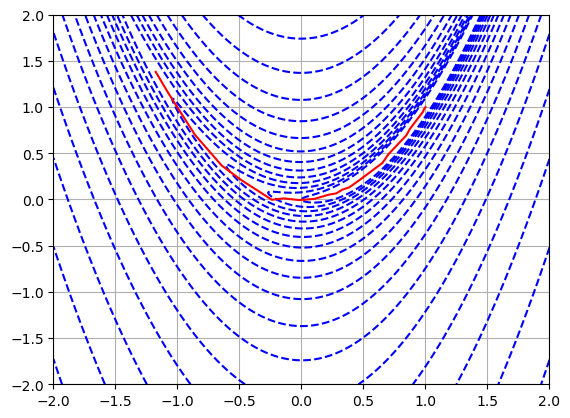

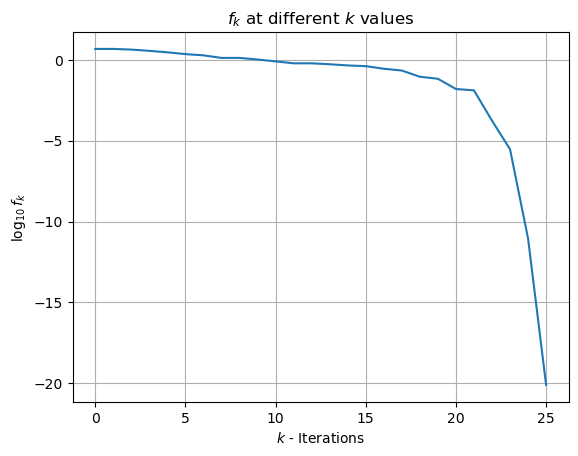

In [6]:
df  = trust_region(f, grad_f, hess_f, np.array([-1.2, 1]), 1, 300, 1/16, 1e-8, 1e2, 1/4, 3/4, 'dogleg')
getInfo(df)

Notice the calculation of $\tau^*$:

$$
\begin{align*}
    ||\bar{p}_k^U + (\tau - 1)(\bar{p}_k^{FS} - \bar{p}_k^U)||^2 &= \Delta_k^2 \\
    \bigg(\bar{p}_k^U + (\tau - 1)(\bar{p}_k^{FS} - \bar{p}_k^U)\bigg)^T \cdot \bigg(\bar{p}_k^U + (\tau - 1)(\bar{p}_k^{FS} - \bar{p}_k^U)\bigg) &= \Delta_k^2 \\
    \bar{p}_k^{UT}\bar{p}_k^U + 2\bar{p}_k^{UT}(\bar{p}_k^{FS} - \bar{p}_k^U)(\tau - 1) + (\bar{p}_k^{FS} - \bar{p}_k^U)^T(\bar{p}_k^{FS} - \bar{p}_k^U)(\tau - 1)^2 &= \Delta_k^2 \\
    (\bar{p}_k^{UT}\bar{p}_k^U - \Delta_k^2) + 2\bar{p}_k^{UT}(\bar{p}_k^{FS} - \bar{p}_k^U)(\tau - 1) + (\bar{p}_k^{FS} - \bar{p}_k^U)^T(\bar{p}_k^{FS} - \bar{p}_k^U)(\tau - 1)^2 &= 0
\end{align*}
$$

Such that we get:

$$
\tau + 1 = \frac{-(2\bar{p}_k^{UT}(\bar{p}_k^{FS} - \bar{p}_k^U)) + \sqrt{(2\bar{p}_k^{UT}(\bar{p}_k^{FS} - \bar{p}_k^U))^2 - 4((\bar{p}_k^{FS} - \bar{p}_k^U)^T(\bar{p}_k^{FS} - \bar{p}_k^U))((\bar{p}_k^{UT}\bar{p}_k^U - \Delta_k^2))}}{2((\bar{p}_k^{FS} - \bar{p}_k^U)^T(\bar{p}_k^{FS} - \bar{p}_k^U))} \\
\tau^* = \frac{-(2\bar{p}_k^{UT}(\bar{p}_k^{FS} - \bar{p}_k^U)) + \sqrt{(2\bar{p}_k^{UT}(\bar{p}_k^{FS} - \bar{p}_k^U))^2 - 4((\bar{p}_k^{FS} - \bar{p}_k^U)^T(\bar{p}_k^{FS} - \bar{p}_k^U))((\bar{p}_k^{UT}\bar{p}_k^U - \Delta_k^2))}}{2((\bar{p}_k^{FS} - \bar{p}_k^U)^T(\bar{p}_k^{FS} - \bar{p}_k^U))} + 1
$$


Number of Iterations:  19


,k,x_k,f_k
0,0,"[2.3761875232684537, 4.905749956978565]",56.730463
1,1,"[2.3669577728078277, 5.602403909961825]",1.868574
2,2,"[2.1597667046365956, 4.624103413554885]",1.508993
3,3,"[2.032288448488, 4.113945632067074]",1.092028
4,4,"[1.7896159404369887, 3.1438373629361323]",0.970271
5,5,"[1.7278189067288392, 2.9815393010745144]",0.531179


,k,x_k,f_k
13,13,"[1.0692072608507406, 1.1426870181456061]",4.816389e-03
14,14,"[1.0064871249679792, 1.0090825172811564]",1.589573e-03
15,15,"[1.0028564673795368, 1.0057079124904396]",8.176782e-06
16,16,"[1.0000075108036717, 1.0000069051101843]",6.644256e-09
17,17,"[1.0000000121726316, 1.0000000242890337]",1.484891e-16
18,18,"[1.000000000000047, 1.0000000000000941]",2.215910e-27


The Minimizer of the function $x^*$: [1. 1.]


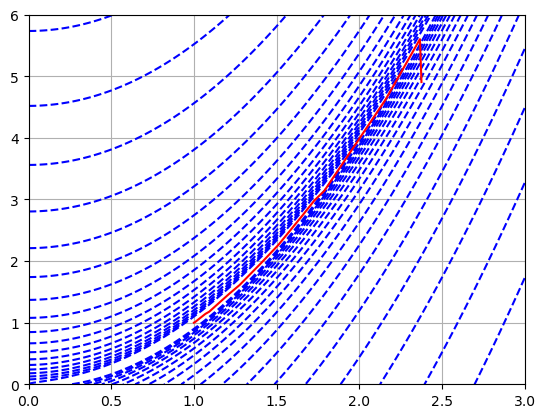

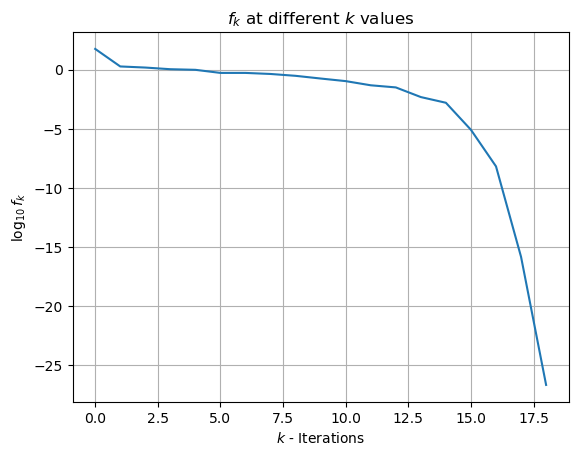

In [9]:
df  = trust_region(f, grad_f, hess_f, np.array([2.8, 4]), 1, 300, 1/5, 1e-8, 1e2, 1/4, 3/4, 'dogleg')
getInfo(df, x1_contour_range=np.linspace(0, 3, 1000), x2_contour_range=np.linspace(0, 6, 1000))

### Problem 2


Experiment with the update rule for the trust region by changing the constants in Algorithm 4.1 in the text Numerical Optimization by Nocedal and Wright 2006. State what you experimented with and discuss your observations


/tmp/ipykernel_197426/1339493156.py:19: RuntimeWarning: invalid value encountered in scalar divide
  rho_k = act_reduct / pred_reduct


With 0.42424242424242425 as the first constant, we were able to minimize the number of iterations to: 21
We can also see that the second constant doesnt matter as for the $||p_k|| = \Delta_k$ is such a hard condition to also meet
Number of Iterations:  21


,k,x_k,f_k
0,0,"[-1.1752808988764047, 1.3806741573033712]",4.731884
1,1,"[-1.1752808988764047, 1.3806741573033712]",4.731884
2,2,"[-1.0059769805158176, 0.9916782476142831]",4.065199
3,3,"[-0.8074199088521758, 0.6167692935741742]",3.390373
4,4,"[-0.5823791687339814, 0.28852216146233856]",2.760399
5,5,"[-0.4401897064293563, 0.17354913445588438]",2.115023


,k,x_k,f_k
15,15,"[0.9183708296210173, 0.8291339593649099]",2.702953e-02
16,16,"[0.9395500834251341, 0.8823057984724776]",3.674313e-03
17,17,"[0.9950233715886466, 0.9869942243079659]",9.717356e-04
18,18,"[0.9981040032490675, 0.9962021110103874]",3.603810e-06
19,19,"[0.9999964081052845, 0.9999892350273308]",1.295398e-09
20,20,"[0.9999999974291945, 0.999999994845506]",6.625638e-18


The Minimizer of the function $x^*$: [1.         0.99999999]


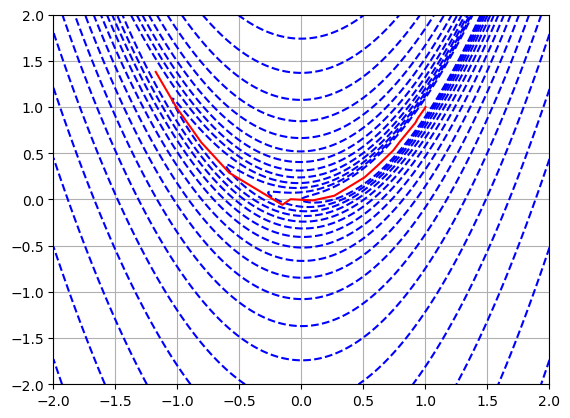

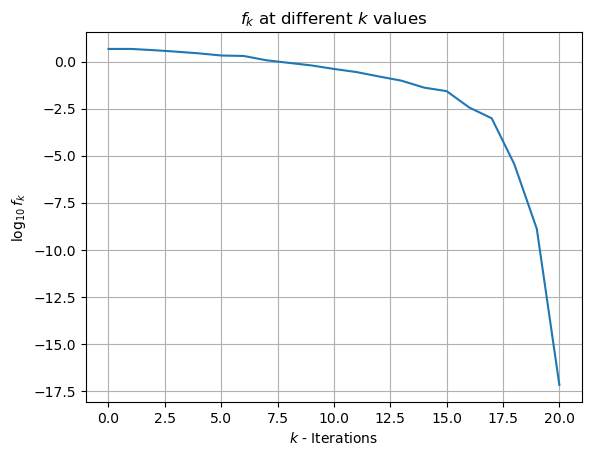

In [45]:
min_num_iters = 100
best_rk_tol1 = 0
for rk_tol1 in np.linspace(0,1,100):
    df  = trust_region(f, grad_f, hess_f, np.array([-1.2, 1]), 1, 300, 1/16, 1e-8, 1e5, rk_tol1, 0, 'dogleg')
    if len(df) < min_num_iters:
        min_num_iters = len(df)
        best_rk_tol1 = rk_tol1

print('With', best_rk_tol1, 'as the first constant, we were able to minimize the number of iterations to:', min_num_iters)
print('We can also see that the second constant doesnt matter as for the $||p_k|| = \Delta_k$ is such a hard condition to also meet')
df  = trust_region(f, grad_f, hess_f, np.array([-1.2, 1]), 1, 300, 1/16, 1e-8, 1e5, best_rk_tol1, 0, 'dogleg')
getInfo(df)

### Problem 3


Write a Program that implements the Cauchy Point. Choose $B_k$ to be the exact Hessian. Apply it to solve Rosenbrock’s function

$$
f(x) = 100(x_2 - x_1^2)^2 + (1 - x_1)^2
$$

Use an initial trust region radius of 1. Set maximum trust region radius to 300.
Use the initial point: $x_0 = [-1.2, 1]$ and then try another point $x_0 = [2.8, 4]$. Do the following for each of the initial points.

Additional information for the Cauchy Point Algorithm:

-   Use $||\nabla f(x_k)|| < 10^{-8}$ as the stopping criteria for your optimization algorithm.
-   State the total number of iterations obtained in your optimization algorithm.
-   Plot the objective function $f(x)$. On the same figure, plot the $x_k$ values at the different iterates of your optimization algorithm.
-   Plot the size of the objective function as a function of the iteration number. Use semi-log plot.
-   You should hand in (i) your code (ii) the first 6 and last 6 values of $x_k$ obtained from your program.
-   Determine the minimizer of the Rosenbrock function $x^*$.


Number of Iterations:  1492


,k,x_k,f_k
0,0,"[-1.0566974440750523, 1.0584908391530399]",4.567782
1,1,"[-1.0308940228699568, 1.0689491107013913]",4.128383
2,2,"[-1.0226013163648087, 1.062097624005203]",4.117760
3,3,"[-1.0257235810682708, 1.0582463886156708]",4.107323
4,4,"[-1.0176719733516826, 1.0518005024601904]",4.097064
5,5,"[-1.0207146012648232, 1.047927341085054]",4.086971


,k,x_k,f_k
1486,1486,"[0.9999999879146088, 0.9999999754874841]",1.577349e-16
1487,1487,"[0.9999999878014888, 0.9999999755561936]",1.490226e-16
1488,1488,"[0.9999999885821312, 0.9999999768414044]",1.407915e-16
1489,1489,"[0.9999999884752594, 0.9999999769063188]",1.330150e-16
1490,1490,"[0.9999999892128272, 0.9999999781206215]",1.256676e-16
1491,1491,"[0.9999999891118553, 0.9999999781819519]",1.187261e-16


The Minimizer of the function $x^*$: [0.99999999 0.99999998]


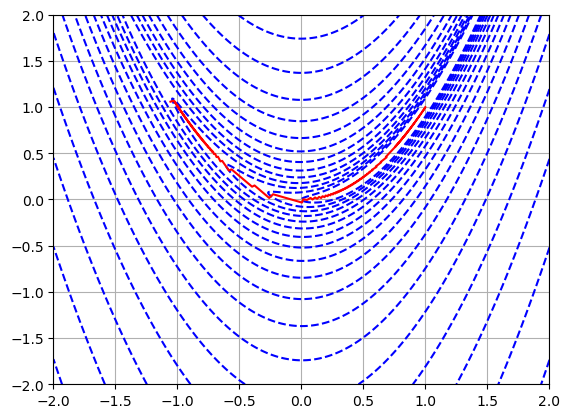

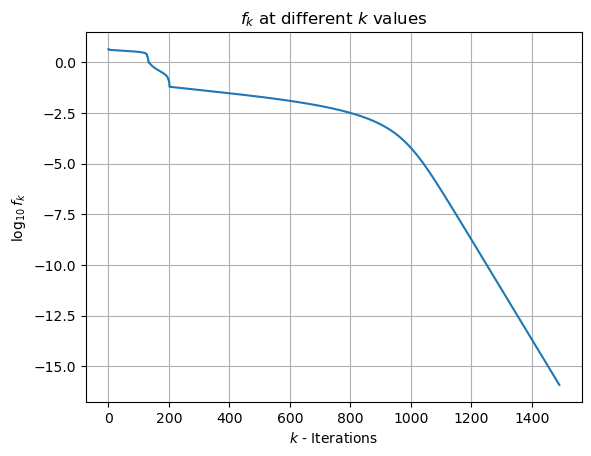

In [10]:
df  = trust_region(f, grad_f, hess_f, np.array([-1.2, 1]), 1, 300, 1/16, 1e-8, 1e5, 1/4, 3/4, 'cauchy')
getInfo(df)

Number of Iterations:  29931


,k,x_k,f_k
0,0,"[2.943519980827422, 7.886619039201581]",64.257574
1,1,"[2.8198554270861993, 7.907536479667989]",3.505898
2,2,"[2.8117508884433438, 7.908875439373302]",3.283301
3,3,"[2.811277748086326, 7.9080228239198815]",3.282974
4,4,"[2.811570454446624, 7.907860344094399]",3.282647
5,5,"[2.8110981853790356, 7.90701038368779]",3.282321


,k,x_k,f_k
29925,29925,"[1.000000009515908, 1.0000000190395368]",9.055847e-17
29926,29926,"[1.0000000094937533, 1.0000000190373912]",9.038020e-17
29927,29927,"[1.0000000094971755, 1.0000000190020566]",9.020228e-17
29928,29928,"[1.0000000094750643, 1.0000000189999152]",9.002471e-17
29929,29929,"[1.0000000094784802, 1.0000000189646516]",8.984750e-17
29930,29930,"[1.0000000094564128, 1.000000018962514]",8.967064e-17


The Minimizer of the function $x^*$: [1.00000001 1.00000002]


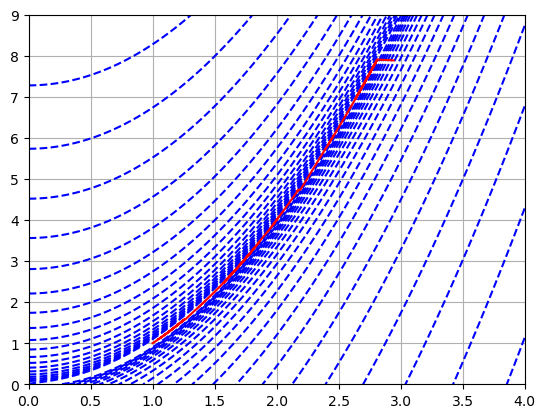

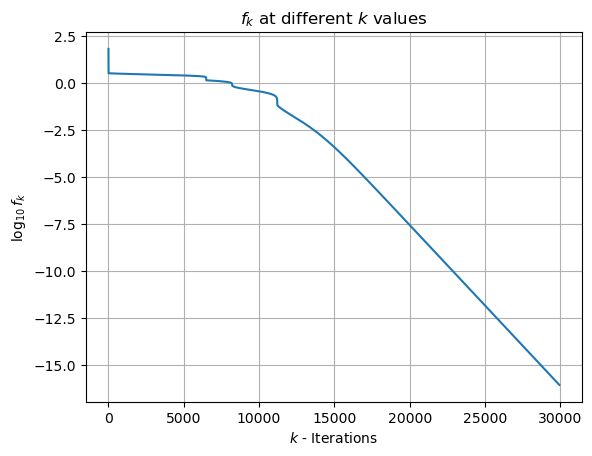

In [15]:
df  = trust_region(f, grad_f, hess_f, np.array([2.4, 8]), 1, 300, 1/16, 1e-8, 1e5, 1/4, 3/4, 'cauchy')
getInfo(df, x1_contour_range=np.linspace(0, 4, 1000), x2_contour_range=np.linspace(0, 9, 1000))